### Import Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../")
from PREDICT import PREDICT
from PREDICT.Models import BayesianModel
from PREDICT.Metrics import *
from PREDICT.Triggers import BayesianRefitTrigger
from PREDICT.Plots import *


%matplotlib inline
import pandas as pd
import numpy as np

import arviz as az
import datetime as dt
from pymc import Model, Normal, sample, math, Bernoulli
from statsmodels.formula.api import logit
from scipy.special import expit

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

RANDOM_SEED = 1
rng = np.random.default_rng(RANDOM_SEED)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


## Bayesian Modelling Example

In this notebook we use Bayesian modelling to refit the model to new data on a monthly basis, to improve predictions. 

We also collect the prior coefficients and observe how they change for each predictor over time.

#### What is Bayesian modelling?

<img src="..\docs\images\bayesian_modelling_robot.png" alt="Bayesian modelling robot cartoon" width="400">

Imagine a robot working in front of a machine with several dials. Each dial controls different settings—maybe one adjusts age, another fine-tunes BMI, and another tweaks systolic blood pressure. __The goal?__ The robot needs to find the perfect combination of dial positions to predict an outcome, like heart attack risk.

At first, the robot doesn’t know the best settings, so it starts by making educated guesses based on prior knowledge (the prior distribution in Bayesian terms). It turns each dial slightly, observing how the machine responds. With every adjustment, the machine gives feedback in the form of new data. The robot carefully updates its beliefs using this feedback—this step is called Bayesian updating, where prior guesses are refined into more accurate ones based on evidence.

Over time, as the robot gathers more data, it becomes more confident in its dial settings. Instead of settling on just one fixed position, it acknowledges uncertainty and considers the range of possible settings that could still produce good results—this forms the posterior distribution.

The beauty of Bayesian regression is that it doesn't just pick one "best" setting; it learns a distribution of possible coefficients, reflecting both certainty and uncertainty. So rather than blindly cranking the dials to one fixed value like traditional regression, the robot constantly adjusts, adapts, and refines its understanding—always ready to improve as more data comes in.

## Pros and Cons of Bayesian Models

### ✅ Pros
- **Incorporates prior knowledge** – Can use existing data or expert beliefs.
- **Provides uncertainty estimates** – Outputs distributions rather than single values.
- **Flexible and adaptable** – Works well with complex models and small datasets.
- **Improves with more data** – Updates predictions as new information comes in.
- **Handles missing data well** – Naturally integrates incomplete datasets.

### ❌ Cons
- **Computationally intensive** – Can be slow, especially with large models.
- **Requires strong priors** – Bad priors can lead to poor results.
- **Harder to interpret** – Probabilistic outputs can be less intuitive than point estimates.
- **Can lead to overfitting** – If priors and data aren’t properly balanced.


### Create some fake data

To reduce the amount of time taken to refit the Bayesian model we have changed the startDate to be closer to the endDate.


In [2]:
mydict = {
    'date': list(),
    'outcome': list(),
    'prediction': list(),
    'age': list(),
    'systolic_bp': list(),
    'flu_symptoms': list()
}

# Set random seed for reproducibility
np.random.seed(42)

records_per_day = 30

# Define date range and COVID shock periods
startDate = pd.to_datetime('01-08-2021', dayfirst=True)  # Start a year before COVID
endDate = pd.to_datetime('31-12-2021', dayfirst=True)  # Include recovery period after COVID
switchDate = pd.to_datetime('01-03-2020', dayfirst=True)  # COVID starts spreading
switchDate2 = pd.to_datetime('01-06-2020', dayfirst=True)  # Peak of the pandemic
recoveryDate = pd.to_datetime('01-06-2021', dayfirst=True)  # Start of recovery phase
numdays = (endDate - startDate).days
switchDays = (switchDate - startDate).days
switch2Days = (switchDate2 - startDate).days
recoveryDays = (recoveryDate - startDate).days

for i in range(numdays):
    curday = startDate + dt.timedelta(days=i)

    age = np.random.normal(70, 5, records_per_day)  # Mean age 70 years, std 5
    systolic_bp = np.random.normal(120, 20, records_per_day)  # Mean systolic blood pressure 120 mmHg, std 10

    # Calculate baseline log-odds
    lp = -1.5 + 0.5 * (age - 70) / 5 + 2 * (systolic_bp - 120) / 10
    curpredictions = 1 / (1 + np.exp(-lp))  # Convert to probability

    # Simulate COVID effects
    if switchDays <= i < switch2Days:
        lp += 1.5  # Initial impact of COVID
    elif switch2Days <= i < recoveryDays:
        lp += 2.0  # Peak of the pandemic
    elif i >= recoveryDays:
        lp -= 1.0  # Recovery period—improved health outcomes

    # Simulate flu symptoms
    if i < switchDays:
        flu_symptoms = np.random.binomial(1, 0.1, records_per_day)  # Low baseline prevalence
    elif i < switch2Days:
        flu_symptoms = np.random.binomial(1, 0.3, records_per_day)  # Increased prevalence during COVID spread
    elif i < recoveryDays:
        flu_symptoms = np.random.binomial(1, 0.5, records_per_day)  # Higher prevalence during pandemic peak
    else:
        flu_symptoms = np.random.binomial(1, 0.2, records_per_day)  # Reduced prevalence during recovery

    # Generate outcomes
    curoutcomes = np.random.binomial(1, 1 / (1 + np.exp(-lp)))  # Simulate "heart attack" events

    # Append to dictionary
    mydict['date'].extend([curday] * records_per_day)
    mydict['outcome'].extend(curoutcomes)
    mydict['prediction'].extend(curpredictions)
    mydict['age'].extend(age)
    mydict['systolic_bp'].extend(systolic_bp)
    mydict['flu_symptoms'].extend(flu_symptoms)

df = pd.DataFrame(mydict)

df.head()

,date,outcome,prediction,age,systolic_bp,flu_symptoms
0,2021-08-01,0,0.025124,72.483571,107.965868,0
1,2021-08-01,1,0.997100,69.308678,157.045564,0
2,2021-08-01,0,0.226156,73.238443,119.730056,0
3,2021-08-01,0,0.006900,77.615149,98.845781,0
4,2021-08-01,0,0.841989,68.829233,136.450898,0


### Set up the Bayesian Model, track some metrics and run the model

The priors can be entered manually (replacing `(None)` with your mean and standard deviation for each predictor `(mean, standard deviation)`) or they can be left as None and the model will generate priors using the input data. However, this does mean the model will take longer to tune to get good predictions.

`refitFrequency` is current at 1, which means the Bayesian model will refit every month (whilst the `timestep` in the PREDICT() class is 'month').

Modeling the probability that outcome==1


Optimization terminated successfully.
         Current function value: 0.259985
         Iterations 8

*** PRIORS ***
Intercept mean coef:  -31.28 ± 1.23
age mean coef:  0.08 ± 0.01
systolic_bp mean coef:  0.19 ± 0.01

*** PRIORS ***
Intercept mean coef: -31.28 ± 1.23
age mean coef: 0.08 ± 0.01
systolic_bp mean coef: 0.19 ± 0.01


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age, systolic_bp]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 182 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Modeling the probability that outcome==1



*** POSTERIORS ***
Intercept mean coef: -45.36 ± 19.33
age mean coef: 0.09 ± 0.01
systolic_bp mean coef: 0.26 ± 0.09

*** PRIORS ***
Intercept mean coef: -45.36 ± 19.33
age mean coef: 0.09 ± 0.01
systolic_bp mean coef: 0.26 ± 0.09


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age, systolic_bp]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 191 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Modeling the probability that outcome==1



*** POSTERIORS ***
Intercept mean coef: -105.67 ± 93.40
age mean coef: 0.09 ± 0.01
systolic_bp mean coef: 0.74 ± 0.69

*** PRIORS ***
Intercept mean coef: -105.67 ± 93.40
age mean coef: 0.09 ± 0.01
systolic_bp mean coef: 0.74 ± 0.69


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age, systolic_bp]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 273 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



*** POSTERIORS ***
Intercept mean coef: -959.22 ± 100.85
age mean coef: 0.11 ± 0.01
systolic_bp mean coef: 7.23 ± 0.78


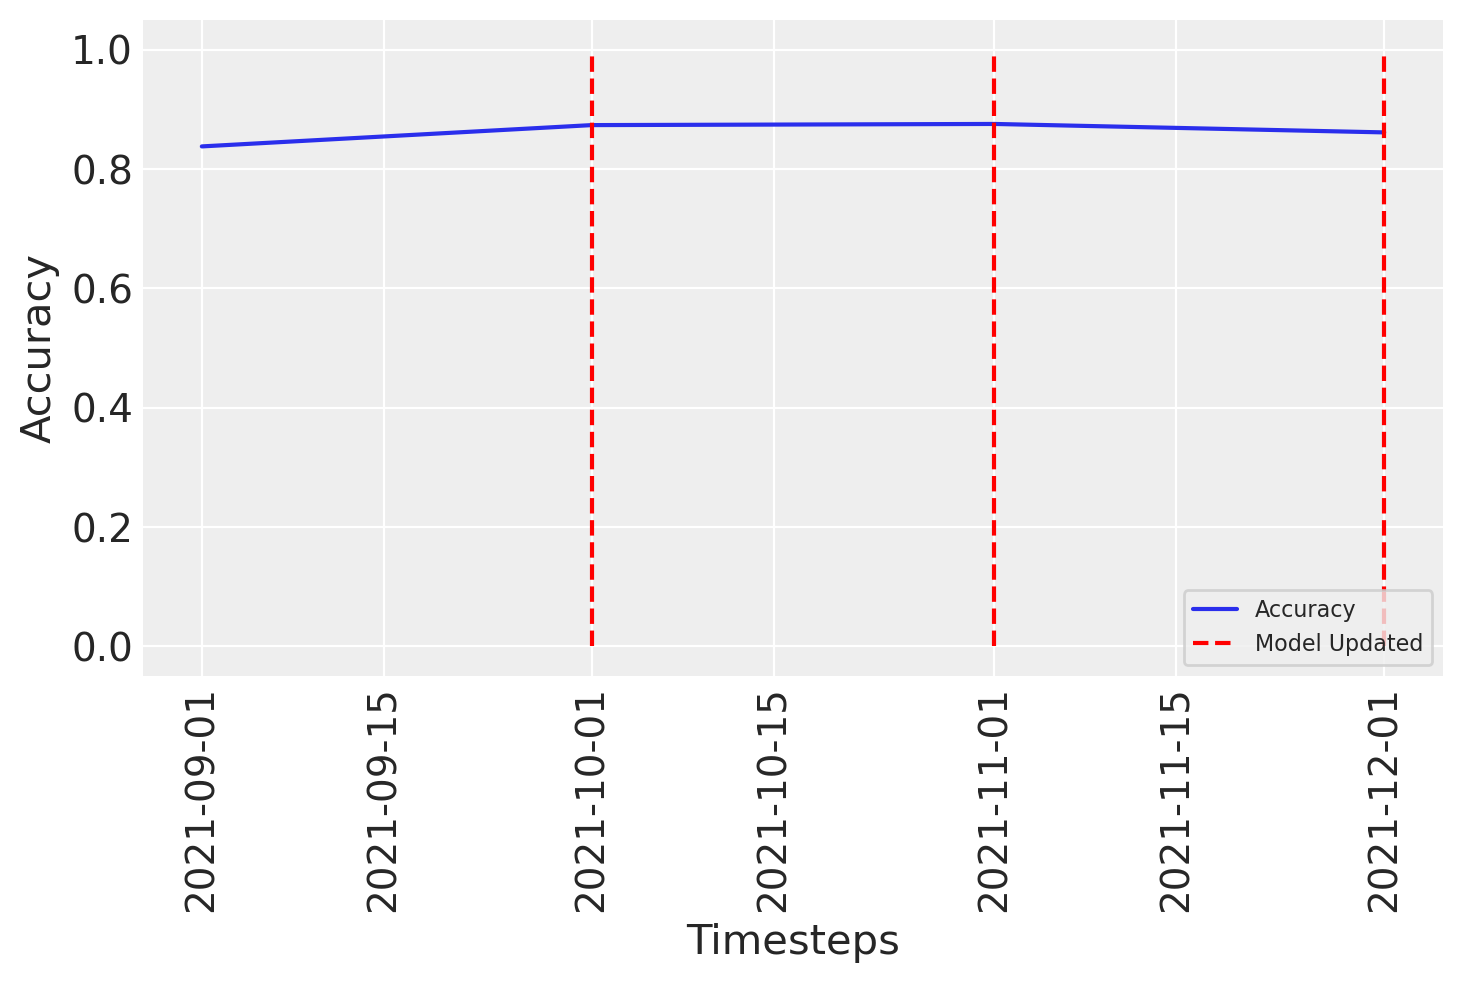

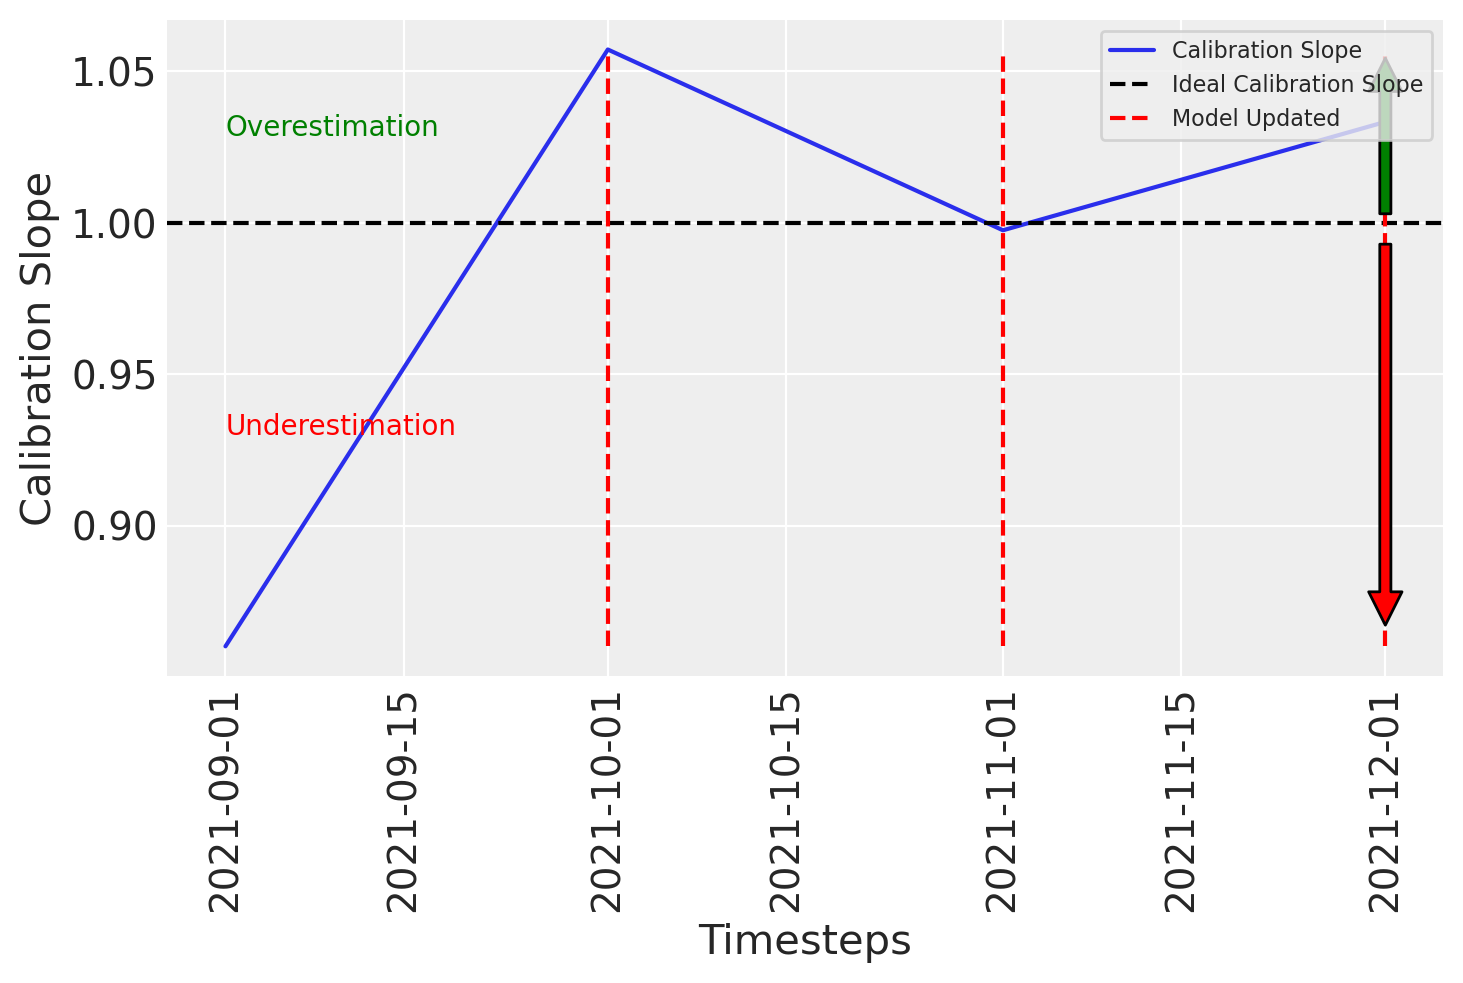

In [3]:
model = BayesianModel(input_data=df, priors={"Intercept": (None), "age": (None), "systolic_bp": (None)})
model.trigger = BayesianRefitTrigger(model=model, input_data=df, refitFrequency=1)

mytest = PREDICT(data=df, model=model, startDate='min', endDate='max', timestep='month')
mytest.addLogHook(Accuracy(model))
mytest.addLogHook(CalibrationSlope(model))
mytest.addLogHook(CITL(model))
mytest.addLogHook(TrackBayesianCoefs(model)) # track the bayesian coefficients over time
mytest.run()
log = mytest.getLog()
AccuracyPlot(log)
CalibrationSlopePlot(log)

### Plot the probability of heart disease vs age

The arguments can be changed to look at another `predictor` such as systolic blood pressure.

`x_axis_min` and `x_axis_max` are the minimum and maximum values (range) that you'd like to look at, this is specific to the predictor you select.

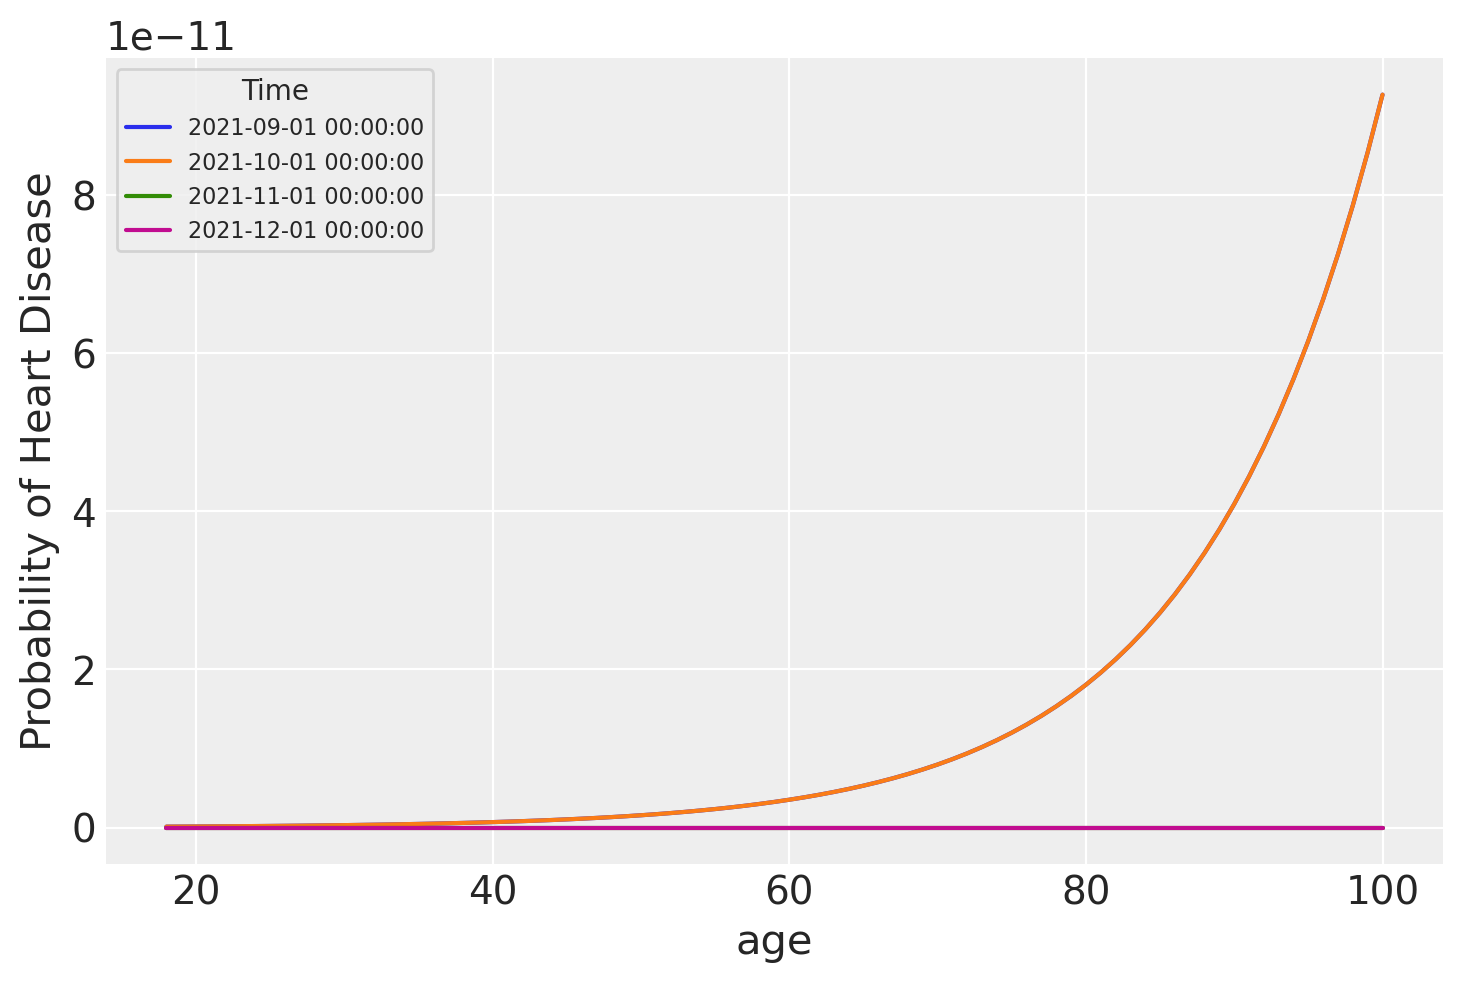

In [4]:
ProbOverTimePlot(log, x_axis_min = 18, x_axis_max=100, predictor="age", outcome="Heart Disease")

### Plot the priors over time to see how the model tunes

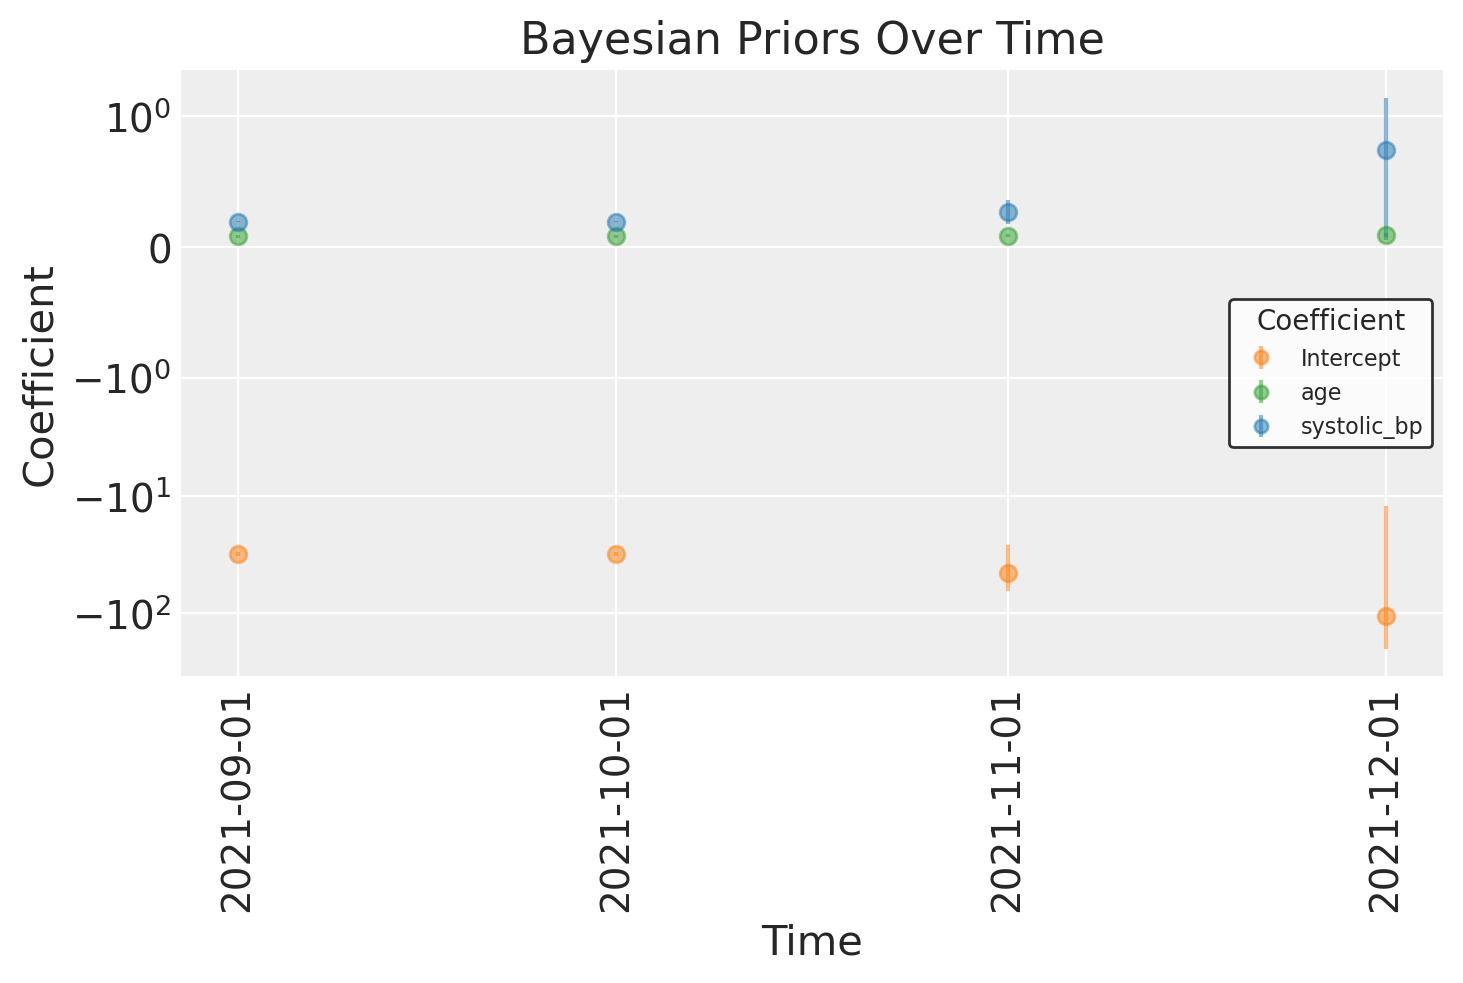

In [5]:
BayesianCoefsPlot(log)